In [1]:
from Model import TorchModelH, ModelH
from InfoSet import InfoSet, Action, Card

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [38]:
info_set = InfoSet([Action.PASS, Action.ADD_CHIP, Action.ADD_CHIP])
info_set.cards = [Card.QUEEN, None]

In [39]:
gen = 172

In [40]:
dfs = []
for i in range(gen+1):
    dfs.append(pd.read_csv(f'training_data/df-{i}.csv'))
df = pd.concat(dfs, axis=0)

In [41]:
ix = (df['facing_action'] == 1) & (df['card'] == 1)
count = df[ix]['opponent_card'].count()
h = (df[ix]['opponent_card'].value_counts() / count).loc[2]

In [42]:
bins = np.arange(0, 1.05, 0.05)  # Bins from 0 to 1 with step 0.1
labels = [f"{b:.2f}-{b+0.05:.2f}" for b in bins[:-1]]  # Label each bin
df['input_p_bin'] = pd.cut(df['input_p'], bins=bins, labels=labels, right=False)

In [43]:
def calculate_h(group):
    # Filter based on 'facing_action' and 'card'
    ix = (group['facing_action'] == 1) & (group['card'] == 1)
    filtered_group = group[ix]
    count = filtered_group['opponent_card'].count()
    if count == 0:
        return np.nan  # Avoid division by zero
    # Calculate the probability of 'opponent_card' being 2
    h = (filtered_group['opponent_card'].value_counts() / count).get(2, 0)
    return h

In [44]:
result = df.groupby('input_p_bin').apply(calculate_h).reset_index(name='h')
result['bin'] = bins[:-1]

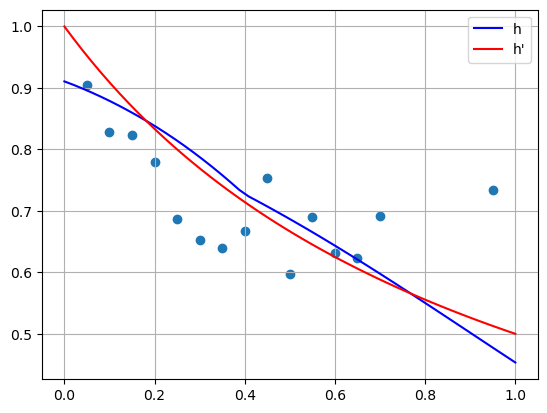

In [46]:
h_model = torch.load(f'model_hmodel/model-{gen}.pt')

ps = []
hs = []
bayes = []

for p in np.linspace(0,1,50):
    model = ModelH(p, 0.99, h_model=h_model, eps=0.05)
    ps.append(p)
    hs.append(model.bayes_prob(info_set)[0][2])
    bayes.append(1/(1+p))

stats = pd.DataFrame({'p': ps, 'h': hs, "h'": bayes})

plt.plot(stats['p'], stats['h'], color='blue', label='h')
plt.plot(stats['p'], stats["h'"], color='red', label="h'")
plt.scatter(result['bin'], result['h'])
plt.legend()
plt.grid(True)